# E3: Test Transforms on IQ2 Debate Corpus

#TODO: List expected results
In this notebook, we expect to see these results for our different transformers:

#### ConversationBalance:
* The host should have a high balance score at the beginning and end when introducing/closing out the debate, but low balance during the rest of the conversation because he does not speak.
* The moderator should have a fairly low balance throughout the conversation, since he is probably mostly calling on different people to answer debate questions.
* The audience should have lower balance in general since they are likely asking questions which have long follow-ups.
* The debaters may have higher balance in the beginning if they are introducing themselves


#### Vocabulary Overlap
* Debaters with the same position (for or against) will have increasingly similar vocabulary as the debate progresses
* Debaters with different positions will have the same or smaller overlap as the debate progresses

### Import dependancies and load corpus

In [1]:
import os
os.chdir("../../") # import convokit
from convokit import Corpus, User, Utterance
os.chdir("datasets/iq2_corpus") # then come back for switchboard
import convokit
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

In [2]:
corpus = Corpus(filename="./corpus")

### Apply all the transformers

We apply the ConversationBalance, VocabOverlap, and FirstImpression transformers. The DAMSLScores transformer does not apply in this case because the DAMSL tags are unique to the Switchboard corpus.

In [3]:
# Apply the ConversationBalance transformer
cb = convokit.ConversationBalance()
cb.transform(corpus)

In [4]:
# Apply the VocabOverlap transformer
vo = convokit.VocabOverlap()
vo.transform(corpus)

In [5]:
# Apply the FirstImpression transformer
fi = convokit.FirstImpression()
fi.transform(corpus)

Bob Costas defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.6808})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Norman Fost defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Richard Pound defaultdict(<class 'float'>, {})
Radley Balko defaultdict(<class 'float'>, {})
Dale Murphy defaultdict(<class 'float'>, {})
Julian Savulescu defaultdict(<class 'float'>, {})
George Michael defaultdict(<class 'float'>, {})
audience defaultdict(<class 'float'>, {})
John Donvan defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.834, 'pos': 0.166, 'compound': 0.9796})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Glenn Hubbard defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Arthur Laffer defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Robert Reich defaultd

Darius Rejali defaultdict(<class 'float'>, {})
Rick Francona defaultdict(<class 'float'>, {})
Jack Cloonan defaultdict(<class 'float'>, {})
audience defaultdict(<class 'float'>, {})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.035, 'neu': 0.851, 'pos': 0.114, 'compound': 0.9769})
John Donvan defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Bjorn Lomborg defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Oliver Tickell defaultdict(<class 'float'>, {})
Peter Huber defaultdict(<class 'float'>, {})
Adam Werbach defaultdict(<class 'float'>, {})
Philip Stott defaultdict(<class 'float'>, {})
L. Hunter Lovins defaultdict(<class 'float'>, {})
audience defaultdict(<class 'float'>, {})
John Donvan defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.836, 'pos': 0.164, 'compound': 0.9136})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Ian Bremmer defaultdict(<class 

Peter Zeihan defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Chrystia Freeland defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
James Rickards defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
audience defaultdict(<class 'float'>, {})
John Donvan defaultdict(<class 'float'>, {'neg': 0.027, 'neu': 0.917, 'pos': 0.056, 'compound': 0.931})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Wendy Shalit defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Lionel Tiger defaultdict(<class 'float'>, {})
Melissa Farley defaultdict(<class 'float'>, {})
Tyler Cowen defaultdict(<class 'float'>, {})
Catharine MacKinnon defaultdict(<class 'float'>, {})
Sydney Barrows defaultdict(<class 'float'>, {})
audience defaultdict(<class 'float'>, {})
John Donvan defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.89, 'pos': 0

Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
audience defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Greg Lukianoff defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Kirsten Powers defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Angus Johnston defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Jeremy Mayer defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
John Donvan defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Binta Niambi Brown defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
W. Keith Campbell defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
David D.

Maajid Nawaz defaultdict(<class 'float'>, {})
Douglas Murray defaultdict(<class 'float'>, {})
audience defaultdict(<class 'float'>, {})
John Donvan defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.889, 'pos': 0.111, 'compound': 0.659})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Philip Gordon defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Thomas Pickering defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Michael Doran defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Mark Dubowitz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
audience defaultdict(<class 'float'>, {})
John Hockenberry defaultdict(<class 'float'>, {'neg': 0.026, 'neu': 0.855, 'pos': 0.119, 'compound': 0.9966})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Heather Mac

Shmuel Bar defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Jeffrey Goldberg defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
audience defaultdict(<class 'float'>, {})
John Donvan defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.818, 'pos': 0.182, 'compound': 0.4404})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Alan Dershowitz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Sanford Levinson defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
David Kopel defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Eugene Volokh defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
audience defaultdict(<class 'float'>, {})
John Donvan defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.795, 'pos': 0.205, 'compound': 0.4767})
Robert Rosenkranz

audience defaultdict(<class 'float'>, {})
Ira Flatow defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.823, 'pos': 0.177, 'compound': 0.743})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Amy L. Friedman defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Sally Satel defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
James F. Childress defaultdict(<class 'float'>, {})
Francis L. Delmonico defaultdict(<class 'float'>, {})
Lloyd R. Cohen defaultdict(<class 'float'>, {})
David Rothman defaultdict(<class 'float'>, {})
audience defaultdict(<class 'float'>, {})
John Donvan defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.717, 'pos': 0.283, 'compound': 0.8074})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Hannah Rosin defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Christina Hoff

John Donvan defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.826, 'pos': 0.174, 'compound': 0.765})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Mustafa Barghouthi defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Daniel Levy defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Dore Gold defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Aaron David Miller defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
audience defaultdict(<class 'float'>, {})
John Donvan defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compound': 0.9601})
Robert Rosenkranz defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Randal C. Picker defaultdict(<class 'float'>, {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0})
Jim Harper defaultdict(<class 'float'>, {})
Harry Lewi

### Measure 1: Conversation Balance

In this section, we will look at the conversation balance. Conversation balance is defined for each user pair as the number of tokens User A spoke over the sum of tokens that User A and User B spoke. Balance is also defined on a statement level. A statement is a group of consecutive utterances spoken by the same user (in the Switchboard corpus, statements were broken into as many as 30 consecutive utterances by the same user). Statement balance is the number of tokens spoken in the current statement over the sum of tokens in the current and next statement.

Let's see what the conversation-level balance looks like.

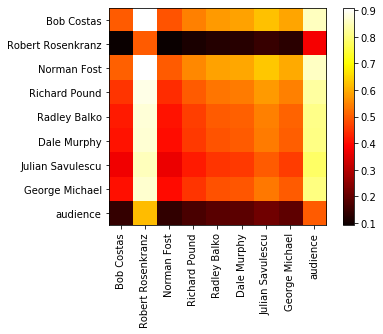

For a perfectly balanced conversation, we would expect low color variation in the plot. Brighter squares (higher scores)
indicate that the person in the row spoke a lot and got a shorter response, while darker squares indicatethat the user said something short and got longer responses.
As expected, the outliers in this plot are:
        1) The host (Robert Rosenkranz), who speaks rarely and only introduces/closes the debate
        2) The audience, which also speaks relatively little during the debate and gets longer responses
We also note that the moderator, Bob Costas has relatively high balance, which is surprising. This means he tends to ask 
longer questions than the responses he receives.


In [6]:
# There are many speakers in the IQ2 conversations, not just two as in switchboard conversations
# We can plot the balance in the conversation as a heatmap. Note the diagonal values should all be 0.5

c = corpus.conversations['0']
balance = c.meta['conversation_balance']
users = c._usernames  

plt.imshow(balance, cmap='hot')
plt.title('')
plt.xticks(np.arange(len(users)),users, rotation=90)
plt.yticks(np.arange(len(users)), users)
plt.ylim(len(users)-0.5, -0.5)
plt.colorbar()
plt.show()
        
print('For a perfectly balanced conversation, we would expect low color variation in the plot. Brighter squares (higher \
scores)\nindicate that the person in the row spoke a lot and got a shorter response, while darker squares indicate\
that the user said something short and got longer responses.')
print('As expected, the outliers in this plot are:\n\
        1) The host (Robert Rosenkranz), who speaks rarely and only introduces/closes the debate\n\
        2) The audience, which also speaks relatively little during the debate and gets longer responses\n\
We also note that the moderator, Bob Costas has relatively high balance, which is surprising. This means he \
tends to ask \nlonger questions than the responses he receives.')

Let's take a quick look at one conversation...

In [7]:
# Looking at just one conversation:
print('Users in this conversation:', corpus.conversations['0']._usernames)

print('\nHere are the IDs for the first 5 utterances of the conversation, and the balance from',
     '\nthis utterance to the next:')
utt_list = corpus.conversations['0']._utterance_ids
for i, u in enumerate(utt_list):
    if 'statement_balance' in corpus.utterances[u].meta:
        name = corpus.utterances[u].user.name
        score = corpus.utterances[u].meta['statement_balance']
        print(u, name, '\t', score)
        
    if i > 4:
        break

print('It looks like the mod, Bob Costas, says many short phrases which are followed up with longer responses by debaters')

Users in this conversation: ['Bob Costas', 'Robert Rosenkranz', 'Norman Fost', 'Richard Pound', 'Radley Balko', 'Dale Murphy', 'Julian Savulescu', 'George Michael', 'audience']

Here are the IDs for the first 5 utterances of the conversation, and the balance from 
this utterance to the next:
0 Bob Costas 	 0.0649895178197065
1 Robert Rosenkranz 	 0.48425624321389793
2 Bob Costas 	 0.2760023242300988
3 Norman Fost 	 0.9952076677316294
4 Bob Costas 	 0.012738853503184714
5 Norman Fost 	 0.9957173447537473
It looks like the mod, Bob Costas, says many short phrases which are followed up with longer responses by debaters


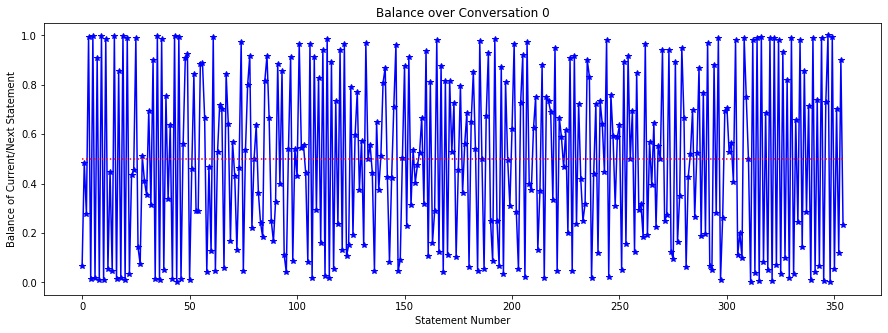

In [8]:
utt_list = corpus.conversations['0']._utterance_ids
statement_ids = []
statement_balances = []

for u in utt_list:
    if 'statement_balance' in corpus.utterances[u].meta:
        statement_ids.append(u)
        statement_balances.append(corpus.utterances[u].meta['statement_balance'])
    
plt.figure(figsize=(15,5))
plt.plot(range(len(statement_balances)), statement_balances, 'b*-')
plt.plot(range(len(statement_balances)), 0.5*np.ones(len(statement_balances)), 'r:')
plt.title('Balance over Conversation 0')
plt.xlabel('Statement Number')
plt.ylabel('Balance of Current/Next Statement')
plt.show()

Based on this plot, it looks like the beginning and end of the conversation have a lot more polarized scores, perhaps from the moderator opening up and closing out the debate. Let's compare the beginning of the debate to the rest.

In [9]:
beg_balance = []
rest_balance = []

for c in corpus.conversations:
    utt_list = corpus.conversations[c]._utterance_ids
    statement_ids = []
    statement_balances = []
    
    # Get list of statement balances
    for u in utt_list:
        if 'statement_balance' in corpus.utterances[u].meta:
            statement_ids.append(u)
            statement_balances.append(corpus.utterances[u].meta['statement_balance'])
            
    # Split up the statements to different parts of the conversation
    split = round(0.1*len(statement_balances))

    beginning = statement_balances[:split]
    rest = statement_balances[split:]
    assert(len(beginning)+len(rest) == len(statement_balances))
    beg_balance.append(sum(beginning)/len(beginning))
    rest_balance.append(sum(rest)/len(rest))
        
print('The average balance of the first 10% of the conversation is:', sum(beg_balance)/len(beg_balance))
print('The average balance of the rest of the conversation is:', sum(rest_balance)/len(rest_balance))

The average balance of the first 10% of the conversation is: 0.5088147927387324
The average balance of the rest of the conversation is: 0.49916076189624664


It doesn't seem as though there is a difference in average balance from the beginning 10% to the rest of the conversation. What if we compare the beginning, middle, and end?

In [10]:
beg_balance = []
mid_balance = []
end_balance = []

for c in corpus.conversations:
    utt_list = corpus.conversations[c]._utterance_ids
    statement_ids = []
    statement_balances = []
    
    # Get list of statement balances
    for u in utt_list:
        if 'statement_balance' in corpus.utterances[u].meta:
            statement_ids.append(u)
            statement_balances.append(corpus.utterances[u].meta['statement_balance'])
            
    # Split up the statements to different parts of the conversation
    split1 = round(0.1*len(statement_balances))
    split2 = round(0.9*len(statement_balances))

    beginning = statement_balances[:split1]
    middle = statement_balances[split1:split2]
    end = statement_balances[split2:]
    
    assert(len(beginning)+len(middle)+len(end) == len(statement_balances))
    
    beg_balance.append(sum(beginning)/len(beginning))
    mid_balance.append(sum(middle)/len(middle))
    end_balance.append(sum(end)/len(end))
        
print('The average balance of the beginning of the conversation is:', sum(beg_balance)/len(beg_balance))
print('The average balance of the middle of the conversation is:', sum(mid_balance)/len(mid_balance))
print('The average balance of the end of the conversation is:', sum(end_balance)/len(end_balance))

The average balance of the beginning of the conversation is: 0.5088147927387324
The average balance of the middle of the conversation is: 0.5020748731202797
The average balance of the end of the conversation is: 0.4758464839477785


It looks as though in the last 10% of the debate, there is slightly lower balance (i.e. people tend to speak less and get longer responses) than the middle or beginning.

### Measure 2: Overlapping use of vocabulary

We hypothesize that speakers with the same position are likely to increase their vocab overlap as the conversation progresses, while people with different positions are likely to have their vocab overlap decrease or remain the same.

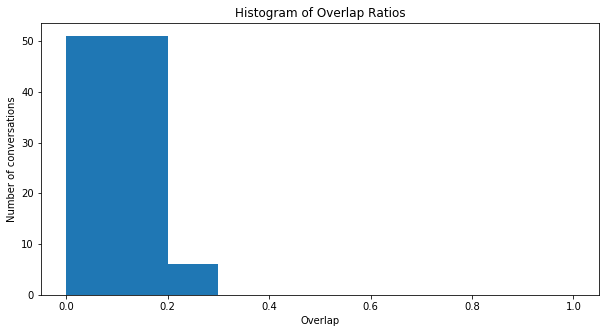

Mean = 0.105698 / StDev = 0.048702


In [11]:
overlaps = []
for i, convo in enumerate(corpus.iter_conversations()):
    
    overlaps.append(convo.meta['vocabulary_overlap']['ratio'])

plt.figure(figsize=(10,5))
plt.hist(overlaps, bins = np.linspace(0,1,num=11))
plt.title('Histogram of Overlap Ratios')
plt.xlabel('Overlap')
plt.ylabel('Number of conversations')
plt.show()

print('Mean = %f / StDev = %f' % (np.mean(overlaps), np.std(overlaps)))

In [12]:
# Observe what words are overlapping across different users
for i, convo in enumerate(corpus.iter_conversations()):
    
    vo = convo.meta['vocabulary_overlap']
    print('+ Overlapping words in convo %s: %s\n' % (convo.id, vo['vocab']))
    if i == 2:
        break

+ Overlapping words in convo 0: {'say', 'debate', 'steroids', 'well', 'us', 'intelligence', 'enhancing', 'make', 'competitive', 'want', 'drugs', 'whether', 'rules', 'would', 'rosenkranz', 'foundation', 'think', 'sports', 'baseball', 'use', 'squared', 'performance', 'thank'}

+ Overlapping words in convo 356: {'taxes', 'going', 'top', 'really', 'would', 'one', 'think', 'rich', 'percent', 'way', 'get', 'point', 'tax', 'well', 'go', 'government', 'raise', 'put'}

+ Overlapping words in convo 671: {'like', 'expression', 'offend', 'include', 'must', 'think', 'freedom', 'speech', 'license', 'well', 'know', 'see', 'free'}



Over all of the debates, it seems that there is relatively little overlap in vocabulary amongst all of the participants.

In [13]:
#TODO: Overlap over time

#### Measure 3: Sentiment analysis for first impressions

As a baseline, we will look at NLTK's VADER sentiment analyzer applied to the IQ2 dataset. We will use the ```compound``` metric, which is NLTK's descriptor of how positive (+1) or negative (-1) the first 10% of a conversation is for each user.

In [14]:
for i, convo in enumerate(corpus.iter_conversations()):
    users = convo.meta['first_impression'].keys()
    for u in users:
        score = convo.meta['first_impression'][u]
#         print(u, score)
    